# ELAIS-S1 master catalogue
## Checks and diagnostics

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
04829ed (Thu Nov 2 16:57:19 2017 +0000)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
plt.style.use('ggplot')

import locale
locale.setlocale(locale.LC_ALL, 'en_GB')

import os
import time
import itertools

from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy import units as u
from astropy import visualization as vis
import numpy as np
from matplotlib_venn import venn2

from herschelhelp_internal.masterlist import nb_compare_mags, nb_ccplots, nb_histograms, find_last_ml_suffix

In [3]:
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = find_last_ml_suffix()
#SUFFIX = "20170711"

master_catalogue_filename = "master_catalogue_elais-s1_{}.fits".format(SUFFIX)
master_catalogue = Table.read("{}/{}".format(OUT_DIR, master_catalogue_filename))

print("Diagnostics done using: {}".format(master_catalogue_filename))

Diagnostics done using: master_catalogue_elais-s1_20170724.fits


## I - Summary of wavelength domains

In [4]:
flag_obs = master_catalogue['flag_optnir_obs']
flag_det = master_catalogue['flag_optnir_det']

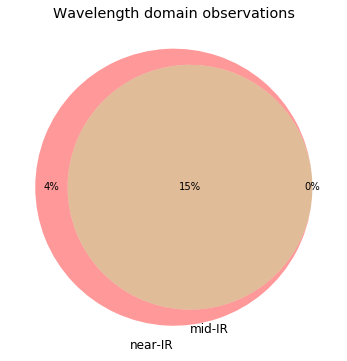

In [5]:
venn2(
    [
        np.sum(flag_obs == 2),
        np.sum(flag_obs == 4),
        np.sum(flag_obs == 6)
    ],
    set_labels=('near-IR', 'mid-IR'),
    subset_label_formatter=lambda x: "{}%".format(int(100*x/len(flag_obs)))
)
plt.title("Wavelength domain observations");

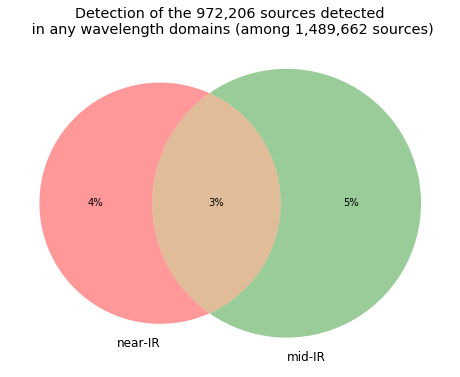

In [6]:
venn2(
    [
        np.sum(flag_det[flag_obs == 6] == 2),
        np.sum(flag_det[flag_obs == 6] == 4),
        np.sum(flag_det[flag_obs == 6] == 6)
    ],
    set_labels=('near-IR', 'mid-IR'),
    subset_label_formatter=lambda x: "{}%".format(int(100*x/np.sum(flag_det != 0)))
)
plt.title("Detection of the {} sources detected\n in any wavelength domains "
          "(among {} sources)".format(
              locale.format('%d', np.sum(flag_det != 0), grouping=True),
              locale.format('%d', len(flag_det), grouping=True)));

## II - Comparing magnitudes in similar filters

The master list if composed of several catalogues containing magnitudes in similar filters on different instruments. We are comparing the magnitudes in these corresponding filters.

In [7]:
r_bands = ["VOICE r"]
y_bands = ["VIDEO y", "VHS y"]
j_bands = ["VIDEO j", "VHS j"]
h_bands = ["VIDEO h", "VHS h"]
k_bands = ["VIDEO k", "VHS k"]

### II.a - Comparing depths

We compare the histograms of the total aperture magnitudes of similar bands.

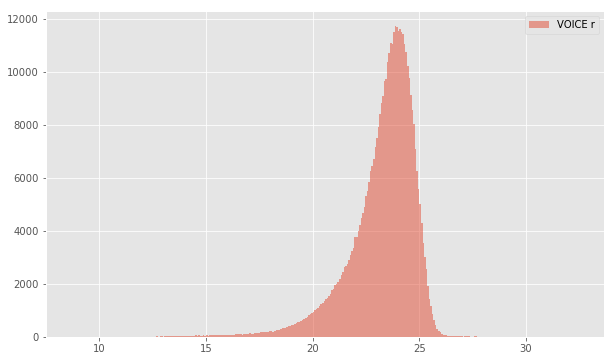

HELP warning: the column m_vhs_y (VHS y) is empty.


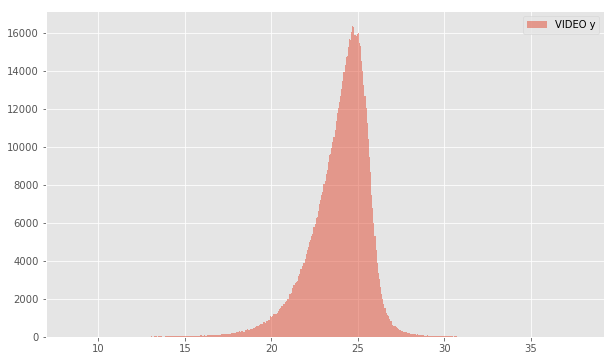

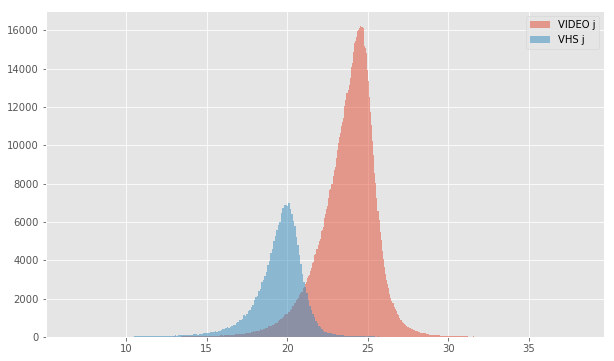

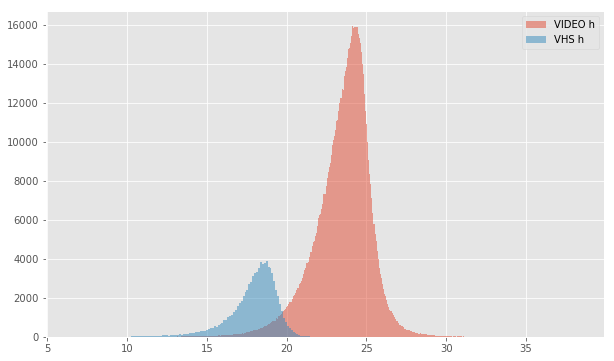

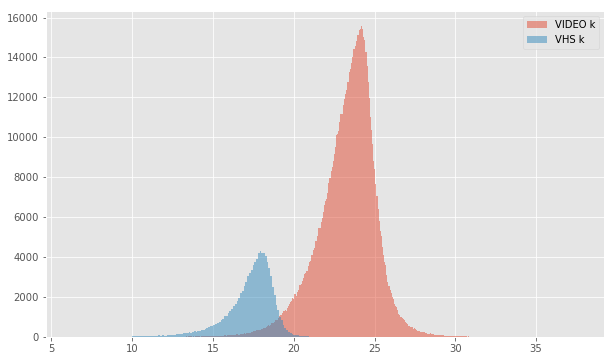

In [8]:
for bands in [r_bands, y_bands, j_bands, h_bands, k_bands]:
    colnames = ["m_{}".format(band.replace(" ", "_").lower()) for band in bands]
    nb_histograms(master_catalogue, colnames, bands)

### II.b - Comparing magnitudes

We compare one to one each magnitude in similar bands.

No sources have both VIDEO y (aperture) and VHS y (aperture) values.
No sources have both VIDEO y (total) and VHS y (total) values.
VHS j (aperture) - VIDEO j (aperture):
- Median: -0.96
- Median Absolute Deviation: 0.12
- 1% percentile: -5.464030494689942
- 99% percentile: -0.49624732971191376


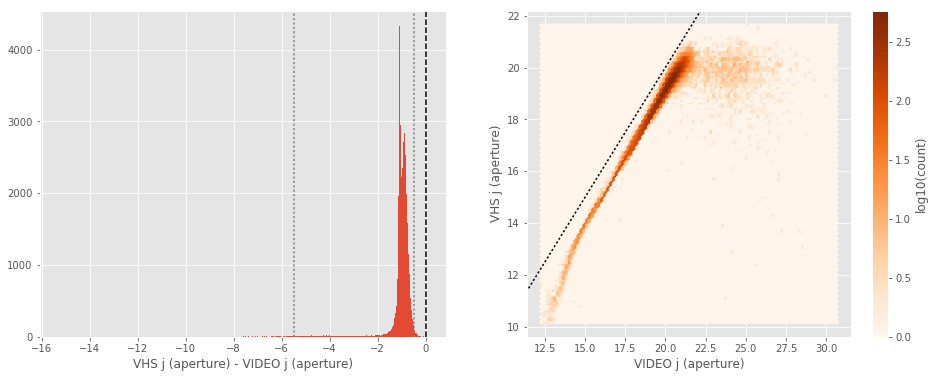

VHS j (total) - VIDEO j (total):
- Median: -0.94
- Median Absolute Deviation: 0.15
- 1% percentile: -5.197365379333496
- 99% percentile: -0.0032662963867162165


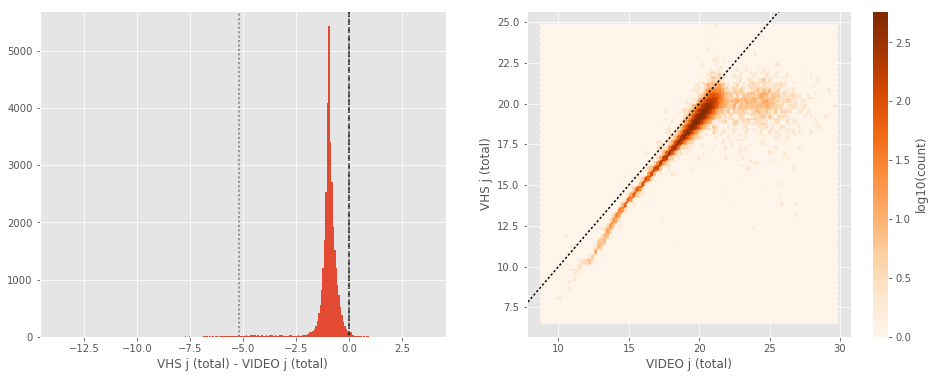

VHS h (aperture) - VIDEO h (aperture):
- Median: -1.36
- Median Absolute Deviation: 0.13
- 1% percentile: -3.7756147384643555
- 99% percentile: -0.8789119720458984


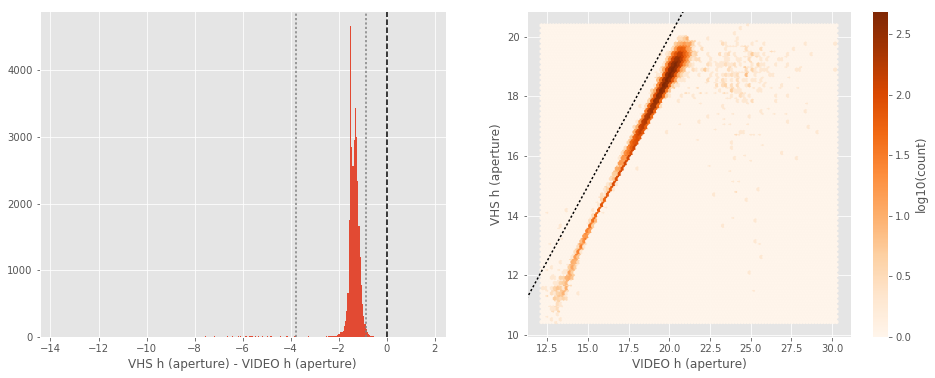

VHS h (total) - VIDEO h (total):
- Median: -1.35
- Median Absolute Deviation: 0.14
- 1% percentile: -3.7320069313049316
- 99% percentile: -0.3897430419921902


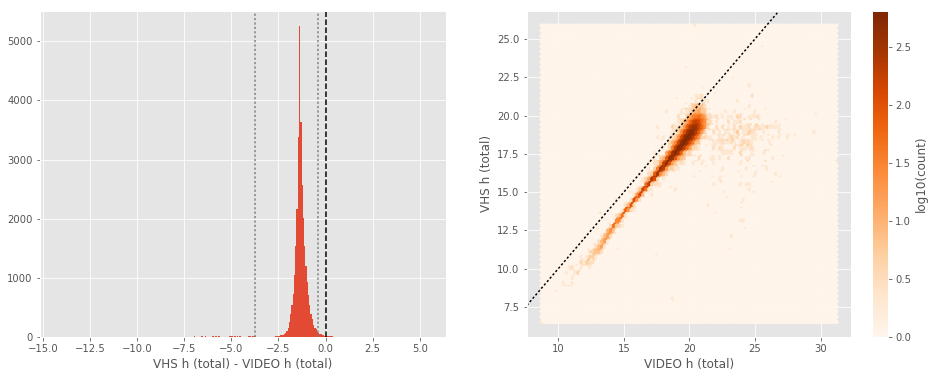

VHS k (aperture) - VIDEO k (aperture):
- Median: -1.77
- Median Absolute Deviation: 0.12
- 1% percentile: -5.313260879516601
- 99% percentile: -1.3076292419433582


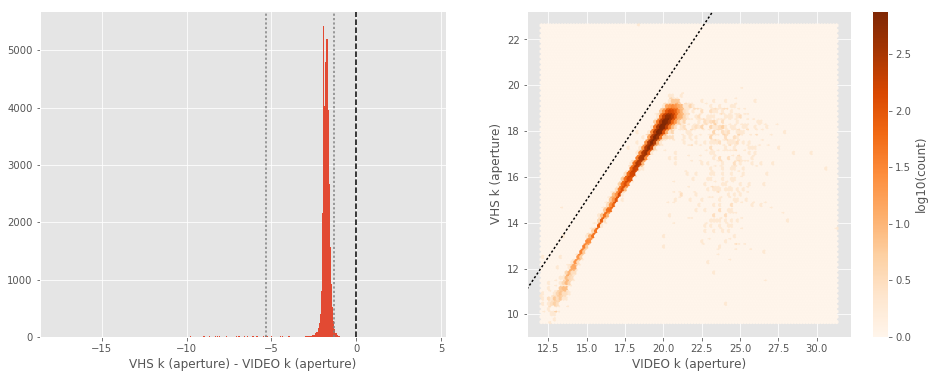

VHS k (total) - VIDEO k (total):
- Median: -1.80
- Median Absolute Deviation: 0.15
- 1% percentile: -4.945708637237549
- 99% percentile: -0.8500444030761735


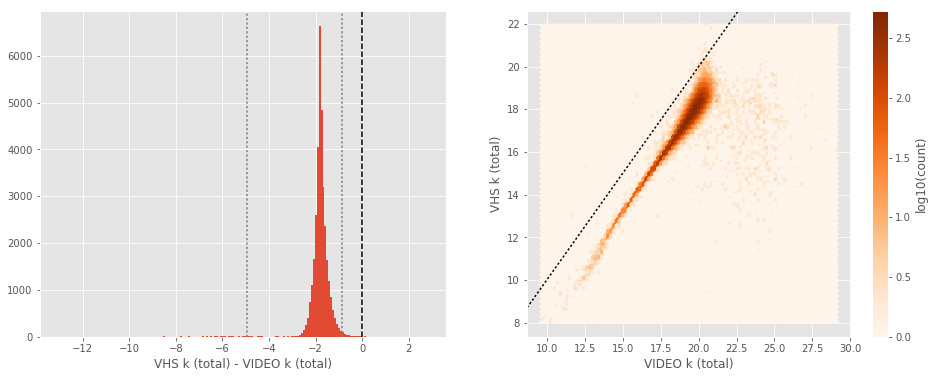

In [9]:
for band_of_a_kind in [r_bands, y_bands, j_bands, h_bands, k_bands]:
    for band1, band2 in itertools.combinations(band_of_a_kind, 2):
        
        basecol1, basecol2 = band1.replace(" ", "_").lower(), band2.replace(" ", "_").lower()
        
        col1, col2 = "m_ap_{}".format(basecol1), "m_ap_{}".format(basecol2)
        nb_compare_mags(master_catalogue[col1], master_catalogue[col2], 
                        labels=("{} (aperture)".format(band1), "{} (aperture)".format(band2)))
        
        col1, col2 = "m_{}".format(basecol1), "m_{}".format(basecol2)
        nb_compare_mags(master_catalogue[col1], master_catalogue[col2], 
                        labels=("{} (total)".format(band1), "{} (total)".format(band2)))

## III - Comparing magnitudes to reference bands

Cross-match the master list to 2MASS magnitudes.

In [10]:
master_catalogue_coords = SkyCoord(master_catalogue['ra'], master_catalogue['dec'])

### III.a - Comparing J and K bands to 2MASS

The catalogue is cross-matched to 2MASS-PSC withing 0.2 arcsecond. We compare the UKIDSS total J and K magnitudes to those from 2MASS.

The 2MASS magnitudes are “*Vega-like*” and we have to convert them to AB magnitudes using the zero points provided on [this page](http://www.ipac.caltech.edu/2mass/releases/allsky/doc/sec6_4a.html):

| Band | Fν - 0 mag (Jy) |
|------|-----------------|
| J    | 1594            |
| H    | 1024            |
| Ks   | 666.7           |

In addition, UKIDSS uses a K band whereas 2MASS uses a Ks (“short”) band, [this page](http://www.ipac.caltech.edu/2mass/releases/allsky/doc/sec6_4b.html) give a correction to convert the K band in a Ks band with the formula:

$$K_{s(2MASS)} = K_{UKIRT} + 0.003 + 0.004 * (J−K)_{UKIRT}$$

In [11]:
# The AB zero point is 3631 Jy
j_2mass_to_ab = 2.5 * np.log10(3631/1595)
k_2mass_to_ab = 2.5 * np.log10(3631/666.7)

In [12]:
twomass = Table.read("../../dmu0/dmu0_2MASS-point-sources/data/2MASS-PSC_ELAIS-S1.fits")
twomass_coords = SkyCoord(twomass['raj2000'], twomass['dej2000'])

idx, d2d, _ = twomass_coords.match_to_catalog_sky(master_catalogue_coords)
mask = (d2d < 0.2 * u.arcsec)

twomass = twomass[mask]
ml_twomass_idx = idx[mask]

VIDEO J (total) - 2MASS J:
- Median: 0.05
- Median Absolute Deviation: 0.07
- 1% percentile: -1.0613550323392702
- 99% percentile: 2.179417935190021


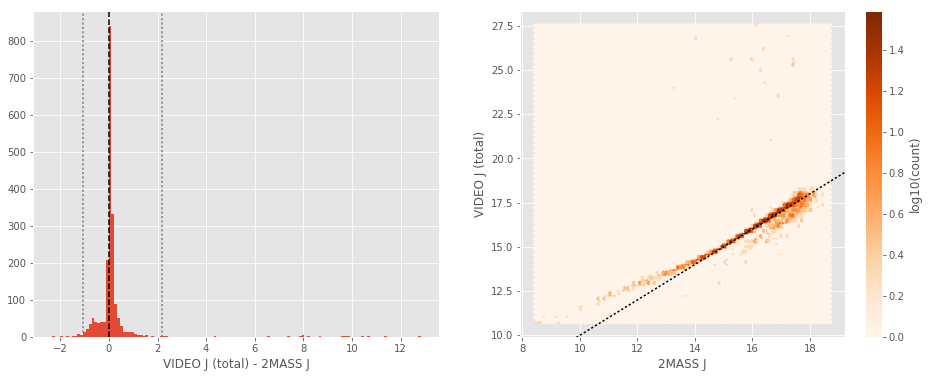

In [13]:
nb_compare_mags(twomass['jmag'] + j_2mass_to_ab, master_catalogue['m_video_j'][ml_twomass_idx],
                labels=("2MASS J", "VIDEO J (total)"))

VHS J (total) - 2MASS J:
- Median: -0.91
- Median Absolute Deviation: 0.06
- 1% percentile: -1.9648990280057732
- 99% percentile: -0.3646072845365369


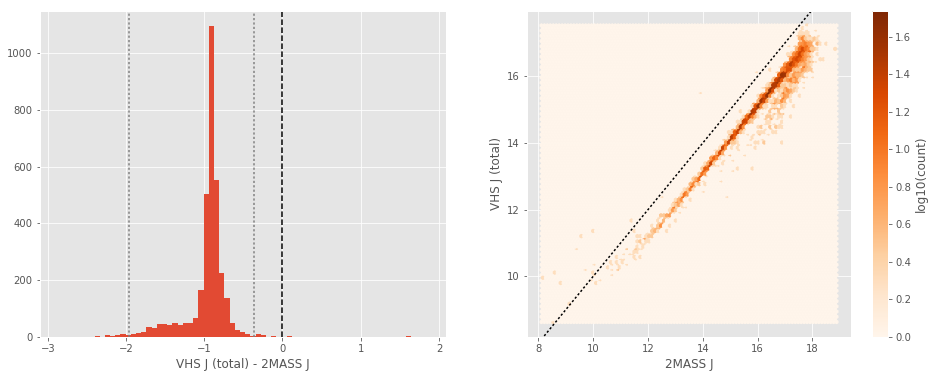

In [14]:
nb_compare_mags(twomass['jmag'] + j_2mass_to_ab, master_catalogue['m_vhs_j'][ml_twomass_idx],
                labels=("2MASS J", "VHS J (total)"))

## Keeping only sources with good signal to noise ratio

From here, we are only comparing sources with a signal to noise ratio above 3, i.e. roughly we a magnitude error below 0.3.

*To make it easier, we are setting to NaN in the catalogue the magnitudes associated with an error above 0.3 so we can't use these magnitudes after the next cell.*

In [15]:
for error_column in [_ for _ in master_catalogue.colnames if _.startswith('merr_')]:
    column = error_column.replace("merr", "m")
    keep_mask = np.isfinite(master_catalogue[error_column])
    keep_mask[keep_mask] &= master_catalogue[keep_mask][error_column] <= 0.3
    master_catalogue[column][~keep_mask] = np.nan

## IV - Comparing aperture magnitudes to total ones.

Number of source used: 406918 / 1489662 (27.32%)


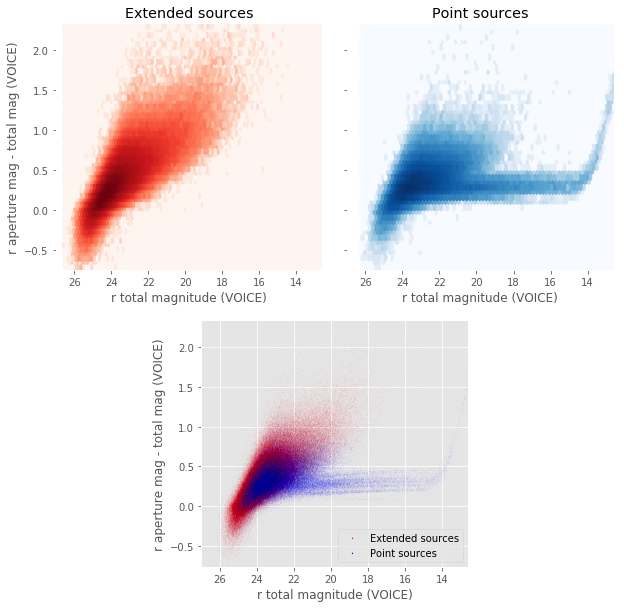

In [16]:
nb_ccplots(
    master_catalogue['m_voice_r'],
    master_catalogue['m_ap_voice_r'] - master_catalogue['m_voice_r'],
    "r total magnitude (VOICE)", "r aperture mag - total mag (VOICE)",
    master_catalogue["stellarity"],
    invert_x=True
)

## V - Color-color and magnitude-color plots

Number of source used: 45573 / 1489662 (3.06%)


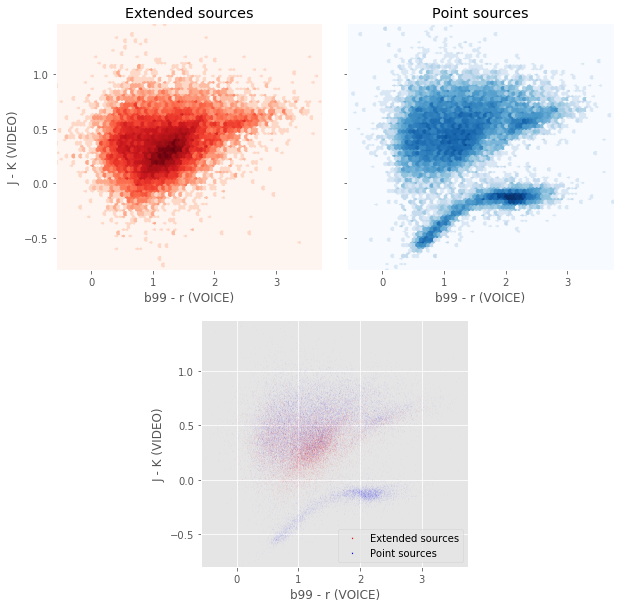

In [17]:
nb_ccplots(
    master_catalogue['m_voice_b99'] - master_catalogue['m_voice_r'],
    master_catalogue['m_video_j'] - master_catalogue['m_video_k'],
    "b99 - r (VOICE)", "J - K (VIDEO)",
    master_catalogue["stellarity"]
)

Number of source used: 39664 / 1489662 (2.66%)


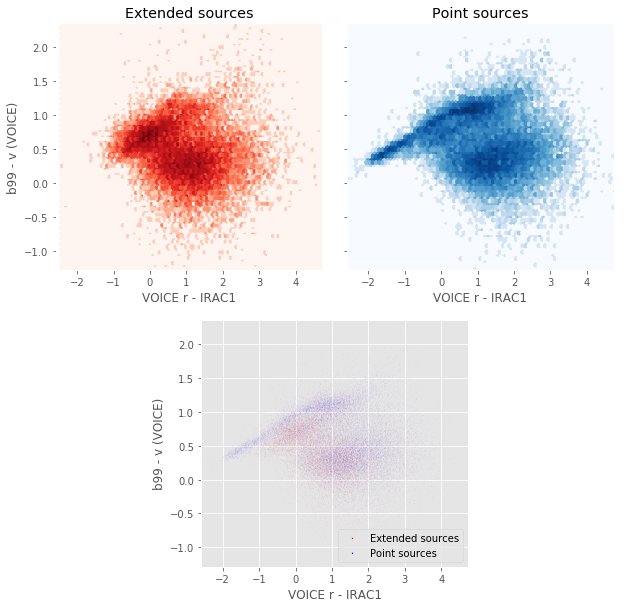

In [18]:
nb_ccplots(
    master_catalogue['m_voice_r'] - master_catalogue['m_irac1'],
    master_catalogue['m_voice_b99'] - master_catalogue['m_voice_v'],
    "VOICE r - IRAC1", "b99 - v (VOICE)",
    master_catalogue["stellarity"]
)

Number of source used: 17556 / 1489662 (1.18%)


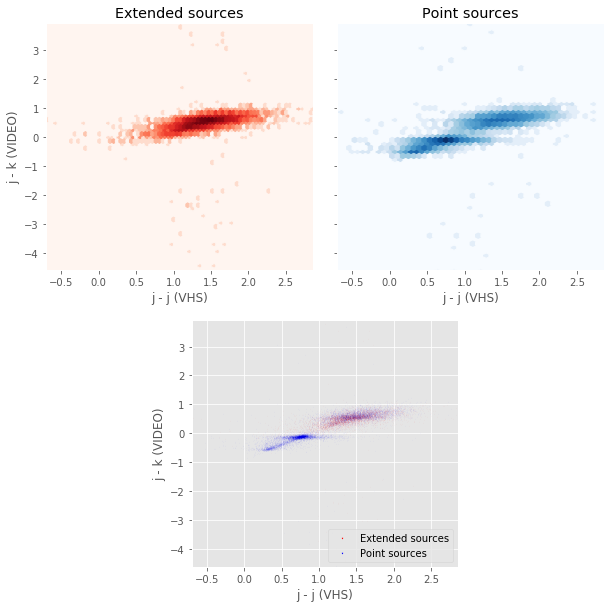

In [19]:
nb_ccplots(
    master_catalogue['m_vhs_j'] - master_catalogue['m_vhs_k'],
    master_catalogue['m_video_j'] - master_catalogue['m_video_k'],
    "j - j (VHS)", "j - k (VIDEO)",
    master_catalogue["stellarity"]
)